In [1]:
# Import
from tqdm import tqdm
import pyprind
import requests
import numpy as np
import pandas as pd
import seaborn as sns
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt

In [2]:
url = 'https://github.com'

# Projectname
project = 'tensorflow'

html = requests.get(url+'/orgs/'+project+'/people').text
bs = BeautifulSoup(html, 'lxml')

def getPeople():
    return [url+person.find('a')['href'] for person in bs.find('div', {'id':'org-members-table'}).findAll('li')]

people = getPeople()

button = bs.find('a', {'class':'next_page'})
while button:
    html = requests.get(url+button['href']).text
    bs = BeautifulSoup(html, 'lxml')

    people.extend(getPeople())
    button = bs.find('a', {'class':'next_page'})

In [3]:
data = []
for person in tqdm(people):
    html = requests.get(person).text
    bs = BeautifulSoup(html, 'lxml')
    for rect in bs.find('div', {'class':'js-calendar-graph is-graph-loading graph-canvas calendar-graph height-full'}).findAll('rect'):
        data.append([rect['data-date'], int(rect['data-count']), person.rsplit('/', 1)[1]])

100%|██████████| 139/139 [02:44<00:00,  1.32s/it]


In [4]:
df = pd.DataFrame(data, columns=['Date', 'Contributions', 'Name'])
df['Date'] = pd.to_datetime(df['Date'])
df = df.set_index('Date')

dict_weekday = {i:day for i, day in enumerate(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])}
df['Weekday'] = [dict_weekday[x] for x in df.index.weekday]

print('Shape: {}'.format(df.shape))

Shape: (50874, 3)


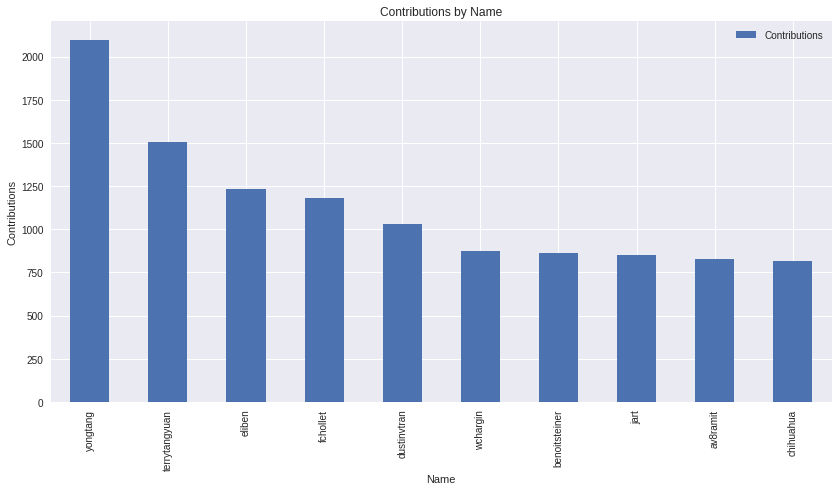

In [18]:
n = 10
most_contribuiting_df = df.groupby('Name').sum().sort_values(by='Contributions', ascending=False).head(n)
most_contribuiting_df.plot(kind='bar', title='Contributions by Name', figsize=(14,7))
plt.ylabel('Contributions')
plt.show()

In [19]:
def plotTimeseries(column, freq='W'):
    df.groupby(pd.TimeGrouper(freq=freq))[column].sum().sort_values(ascending=False).plot()
    plt.title('{} Team {} by {}'.format(project, column, freq))
    plt.ylabel(column)
    plt.show()

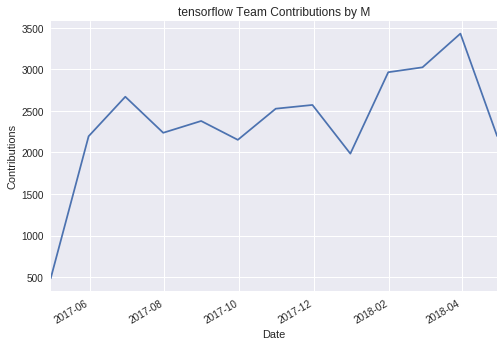

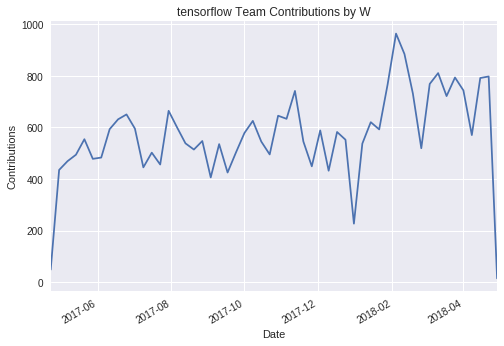

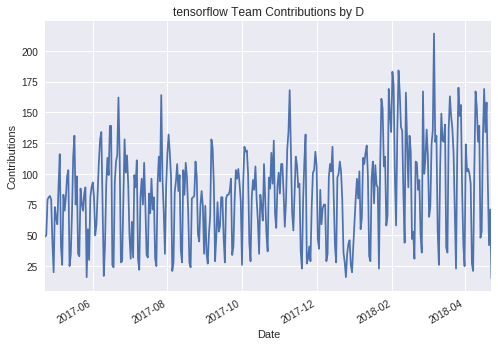

In [20]:
for i in ['M', 'W', 'D']:
    plotTimeseries('Contributions', freq=i)

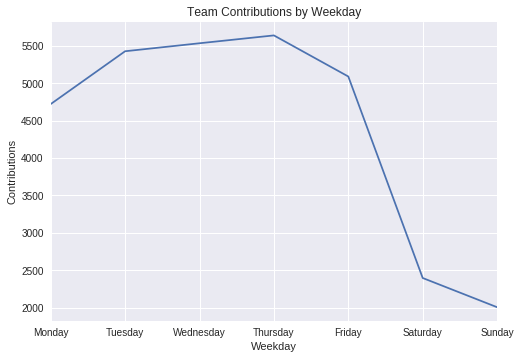

In [21]:
column = 'Contributions'
group = 'Weekday'
_, week_order = zip(*dict_weekday.items())
df.groupby([group])[column].sum().reindex(index=week_order).plot()
plt.title('Team {} by {}'.format(column, group))
plt.ylabel(column)
plt.show()

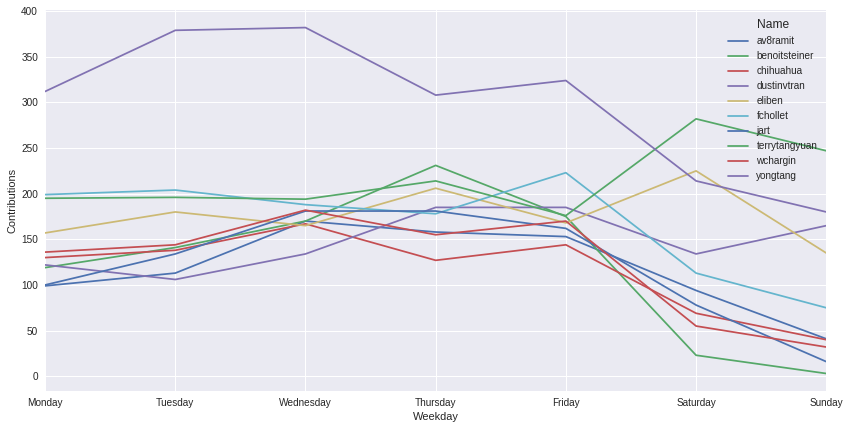

In [23]:
_, week_order = zip(*dict_weekday.items())

df[df['Name'].isin(most_contribuiting_df.index)].pivot_table(index=df[df['Name'].isin(most_contribuiting_df.index)].index.weekday, columns='Name', values='Contributions', aggfunc='sum').plot(figsize=(14,7))
plt.xlabel('Weekday')
plt.ylabel('Contributions')
plt.xticks(range(7), week_order)
plt.show()